In [1]:
import pandas as pd
import numpy as np

#time
from datetime import datetime
import calendar
import time

#plots
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

import plotly.io as pio
pio.renderers.default="notebook"

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns


# #sklearn
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression

# #torch
# import torch

#time series analysis
import statsmodels.tsa.stattools as sts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<a name='part2'></a>
# 2. Data cleaning and preprocessing



In [40]:
def add_calendar_features(df):
    df_new = df.copy()
    df_new['ts'] = pd.Timestamp('2019-01-01')+pd.to_timedelta(df_new.index, unit='H')
    df_new.set_index(['ts'], inplace=True)
    df_new["Month"] = pd.DatetimeIndex(df_new.index).month
    df_new["Hour"] = pd.DatetimeIndex(df_new.index).hour
    df_new["Day of Week"] = pd.DatetimeIndex(df_new.index).dayofweek
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Day of Week"], "dow")], axis=1)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Hour"], "hod")], axis=1)
    df_new = pd.concat([df_new, pd.get_dummies(df_new["Month"], "month")], axis=1)

    return df_new



In [41]:
df_dw = pd.read_csv("data/balance_dw.csv")
df_up = pd.read_csv("data/balance_up.csv")
df_dw.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)
df_up.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)
df_up = add_calendar_features(df_up)
df_dw = add_calendar_features(df_dw)


In [43]:
def plot_time_data(df, columnName):
    df_month = df.groupby(["Month"]).mean().reset_index()
    df_dow = df.groupby(["Day of Week"]).mean().reset_index()
    df_hod = df.groupby(["Hour"]).mean().reset_index()


    fig = make_subplots(rows=1, cols=3, subplot_titles=["Hour of Day", "Day of Week", "Month"])

    fig.update_layout(
        barmode='group',
        title_text="Average electricity price grouped by hour of day, day of week and month"
    )

    months = [calendar.month_abbr[i] for i in range(1,13)]
    dows = [calendar.day_abbr[i] for i in range(0,7)]
    hods = ["0"+str(i)+":00" if i < 10 else str(i)+":00" for i in range(0,24)]

    fig.append_trace(go.Bar(x=months, y=df_month[columnName], marker_color="blue", showlegend=False), row=1, col=3)
    fig.append_trace(go.Bar(x=dows, y=df_dow[columnName], marker_color="blue", showlegend=False), row=1, col=2)
    fig.append_trace(go.Bar(x=hods, y=df_hod[columnName], marker_color="blue", showlegend=False), row=1, col=1)

    fig.update_yaxes(title_text="Average electricity price DKK/MWh", row=1, col=1)

    fig.show()

In [45]:
plot_time_data(df_dw, df_dw.columns[0])

# Looks like balancing price follows DA price! Not surprising, since it is often equal to DA and otherwise bounded by DA. Maybe we should consider PENALTY instead of balancing price...

In [46]:
# Plot to display the time series, ACF and PACF
# This code was adapted from the blog Seanabu.com
def tsplot(y, lags=25, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        plt.figure(figsize=figsize) # Set the size of the figure
        
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')


        plt.tight_layout()
    return 

In [47]:
#create pd series with only spotprice
ts = df_dw[df_dw.columns[0]]

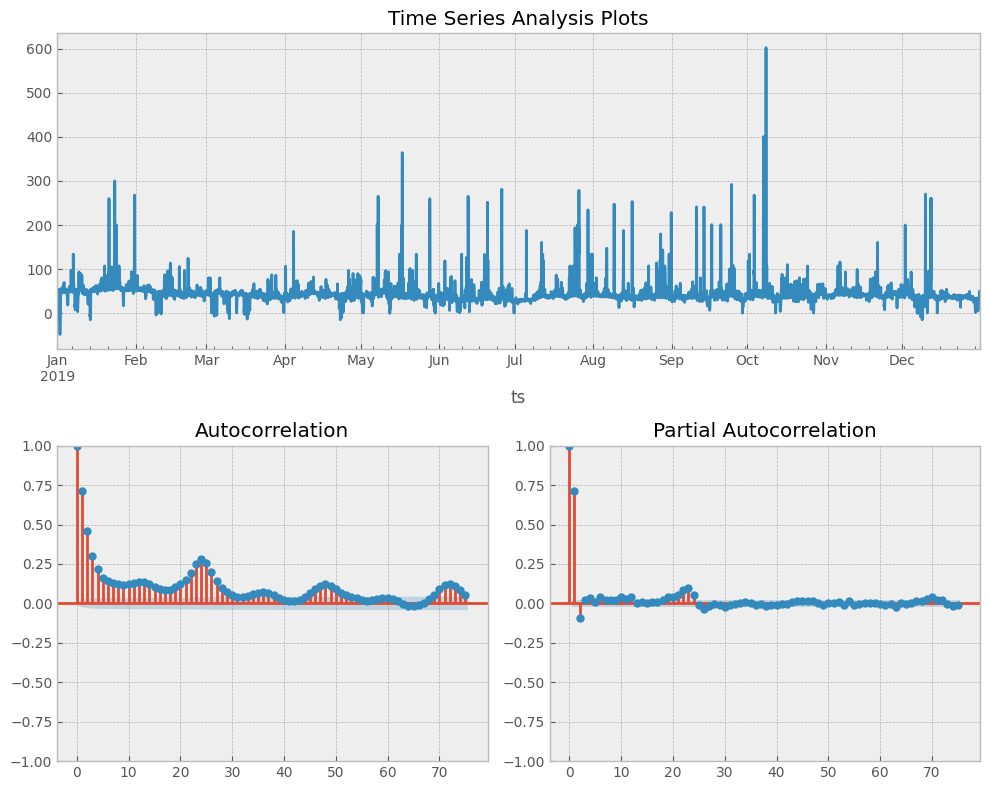

In [48]:
tsplot(ts, lags = 75)

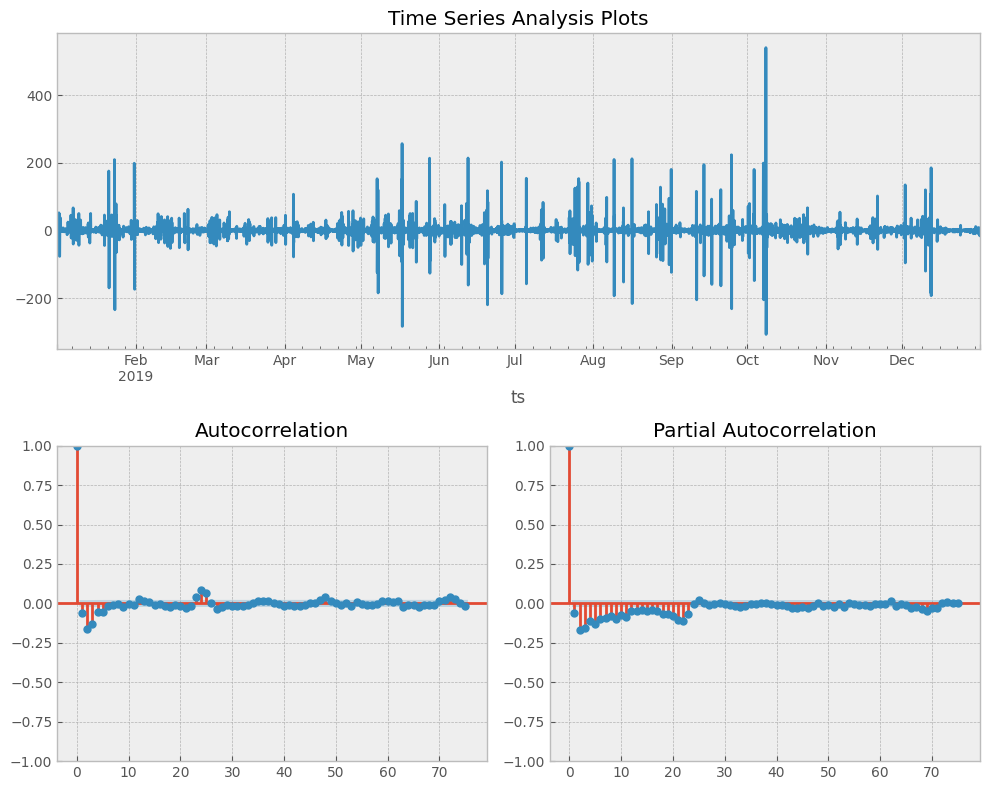

In [49]:
ts_diff = ts.diff(periods=1).dropna()
tsplot(ts_diff,lags =75)

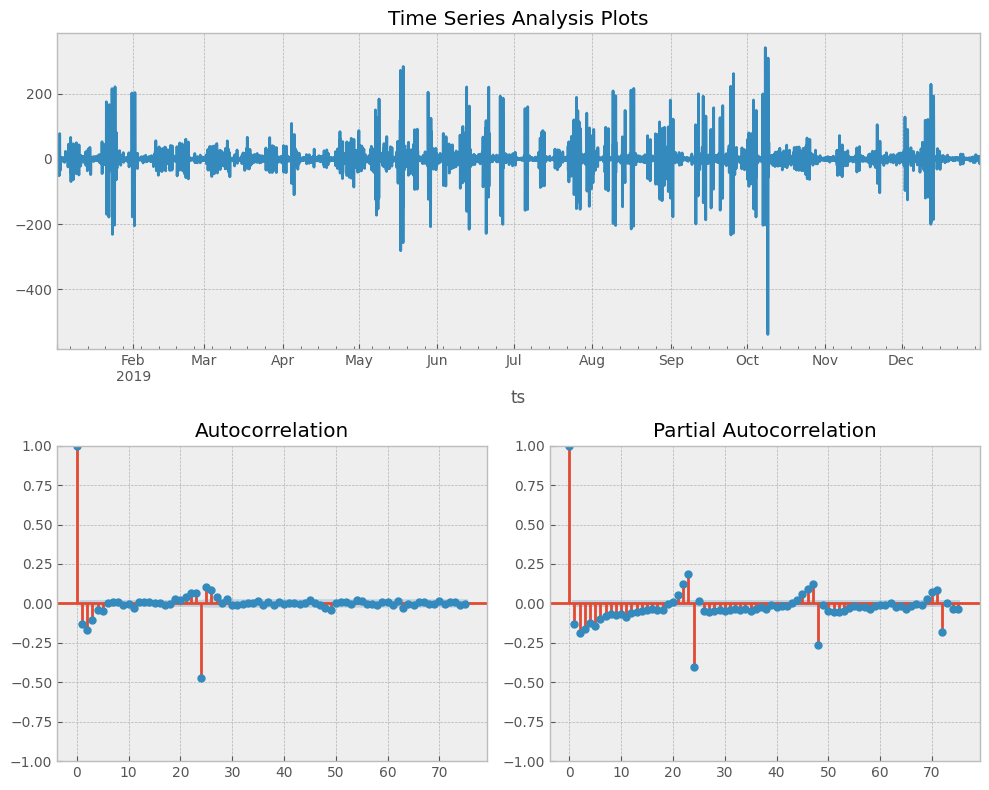

In [50]:
ts_diff2 = ts.diff(periods=1).diff(periods=24).dropna()
tsplot(ts_diff2, lags = 75)

In [52]:
columnName = 'Generation / - Imbalance price [EUR/MWh] - MBA|DK2'
ts = df_dw[[columnName]].copy()

# Standardize based on training set
ts_mean = ts[:"2019-10-01"].mean()
ts_std = ts[:"2019-10-01"].std()
ts[f"{columnName}_std"] = (ts - ts_mean)/ts_std

#diff in standardized domain
ts["diff1"] = ts[f"{columnName}_std"].diff(1)    # Transform with 1h diff
ts["diff2"] = ts["diff1"].diff(24)              # Transform with 24h diff

#create function that transforms back into original domain
def getPriceDomain(df):
  diff1 = df['diff1'].shift(24) + df['diff2']     # Reverse the 24h diff
  ori = df[f'{columnName}_std'].shift(1) + diff1   # Reverse the 1h diff
  return ori


ts["ori_std"] = getPriceDomain(ts)
ts.iloc[24:,:]

,Generation / - Imbalance price [EUR/MWh] - MBA|DK2,Generation / - Imbalance price [EUR/MWh] - MBA|DK2_std,diff1,diff2,ori_std
ts,,,,,
2019-01-02 00:00:00,-33.57,-3.191800,-3.135129,NaN,NaN
2019-01-02 01:00:00,-45.92,-3.697466,-0.505666,0.241573,-3.697466
2019-01-02 02:00:00,-48.29,-3.794504,-0.097039,0.482327,-3.794504
2019-01-02 03:00:00,-33.60,-3.193028,0.601476,0.840183,-3.193028
2019-01-02 04:00:00,-33.54,-3.190571,0.002457,-0.099905,-3.190571
...,...,...,...,...,...
2019-12-31 19:00:00,44.73,0.014163,0.316502,0.323462,0.014163
2019-12-31 20:00:00,50.35,0.244272,0.230109,0.346801,0.244272
2019-12-31 21:00:00,34.48,-0.405519,-0.649791,-0.612941,-0.405519


<a name="part5"></a>
# 5 AR model

In [74]:
from sklearn.metrics import r2_score

def get_score(y_test, y_hat):
  corr, mae, rae, rmse, _ = compute_error(y_test, y_hat)
  r2 = r2_score(y_test, y_hat)
  print("CorrCoeff: ", corr)
  print("MAE: ", rae)
  print("RMSE: ", rmse)
  print("R2: ", r2)

#define function that calculates performance of model
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

<a name="part5.1"></a>
## 5.1 AR(2)

The first temporal model we will define is a simple AR(2). A $\beta$ coefficient is sampled for each AR term, as well as a noise value for each timestep, resulting in the following generative process:

1. Sample AR coefficients and noise variance

  *   $\beta_1$ ~ $N(\beta_1 | 0, 3)$
  *   $\beta_2$ ~ $N(\beta_2 | 0, 3)$
  *   $\tau$ ~ $HalfCauchy(\tau | 3)$
2. Sample initial hidden states:
  *   $z_{1}$ ~ $N(z_{1}|0, 5)$
  *   $z_{2}$ ~ $N(z_{2}|0, 5)$
3. For each timestep $t=\{3, ..., T\}$:
  *   $z_{t}$ ~ $N(z_t | \beta_1 z_{t-1} + \beta_2 z_{t-2},  \tau)$
  *   $y_t$ ~ $N(y_t | z_t, \sigma)$

The model is defined along with the carry function for the lax scan procedure. Generally for all models throughout the notebook, the scales have initially been set to values similar to those used in playtime exercises, but have been iteratively adjusted based on model performance throughout the project. This was done by trial and error, and is therefore not documented is this notebook. In the actual implementation, the noise is sampled for each timestep beforehand and $z_t$ is calculated directly with the noise being scaled by $\tau$, which is completely equivalent to the sampling of $z_t$ described in the generative above. 

In [53]:
#numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

#jax
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

In [54]:
def f(carry, noise_t):
    beta1, beta2, z_prev1, z_prev2, tau = carry
    z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, z_prev1, z_prev2, tau), z_t

In [55]:
def model(T, T_forecast, obs=None):
    beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=3.))
    beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=3.))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(T+T_forecast-2,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=1.))
    z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0, scale=5.))
    z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0, scale=5.))    

    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    return z_collection

In [60]:
#define features
non_dummy_features = []
features = [f"dow_{i}" for i in range(7)] \
    + [f"hod_{i}" for i in range(24)]

#create X and y
X = df_dw[features]
y = df_dw[[columnName]]

# displace X and y
X_displaced = X.iloc[:-1,:]
for attr in features:
  if attr in non_dummy_features:
    X_displaced[attr] = X[attr][1:].to_numpy()
  else:
    X_displaced[attr] = X[attr][:-1].to_numpy()

y_displaced = y[:-1]

X = X_displaced
y = y_displaced

X_means = [X[attr][:"2019-10-01"].mean() for attr in non_dummy_features]
X_stds = [X[attr][:"2019-10-01"].std() for attr in non_dummy_features]
y_mean = y[:"2019-10-01"].mean()[0]
y_std = y[:"2019-10-01"].std()[0]

# standardize X and y based on train set
for i, attr in enumerate(non_dummy_features):
  X[attr] = (X[attr] - X_means[i]) / X_stds[i]

y = (y - y_mean) / y_std

# Final train and test sets
X_train = X[:"2019-10-01"].to_numpy()
y_train = y[:"2019-10-01"].to_numpy()
X_test = X["2019-10-01":].to_numpy()
y_test = y["2019-10-01":].to_numpy()

/tmp/ipykernel_20988/1553322154.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
#numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

In [64]:

def run_MCMC(model, y_train, T, T_forecast, num_samples=4000, num_warmup=1000, print_summary=False):
  t0 = time.time()

  rng_key = random.PRNGKey(0)
  rng_key, rng_key_ = random.split(rng_key)

  nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
  mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=1)
  mcmc.run(rng_key_, T=T, T_forecast=T_forecast, obs=y_train)

  t_fin = time.time()

  print("Total time: {0:.3f}m".format((t_fin - t0)/60))

  if print_summary:
    mcmc.print_summary()

  return mcmc

In [68]:
# Split dataset
y_train = ts["diff2"][:"2019-10-01"].dropna().to_numpy()
y_test = ts["diff2"]["2019-10-01":].to_numpy()


# Run algorithm
mcmc = run_MCMC(model, y_train, len(y_train), len(y_test))

sample: 100%|██████████| 5000/5000 [10:38<00:00,  7.83it/s, 255 steps of size 5.00e-03. acc. prob=0.98]

Total time: 10.727m


Let's take a look at the resulting distributions.

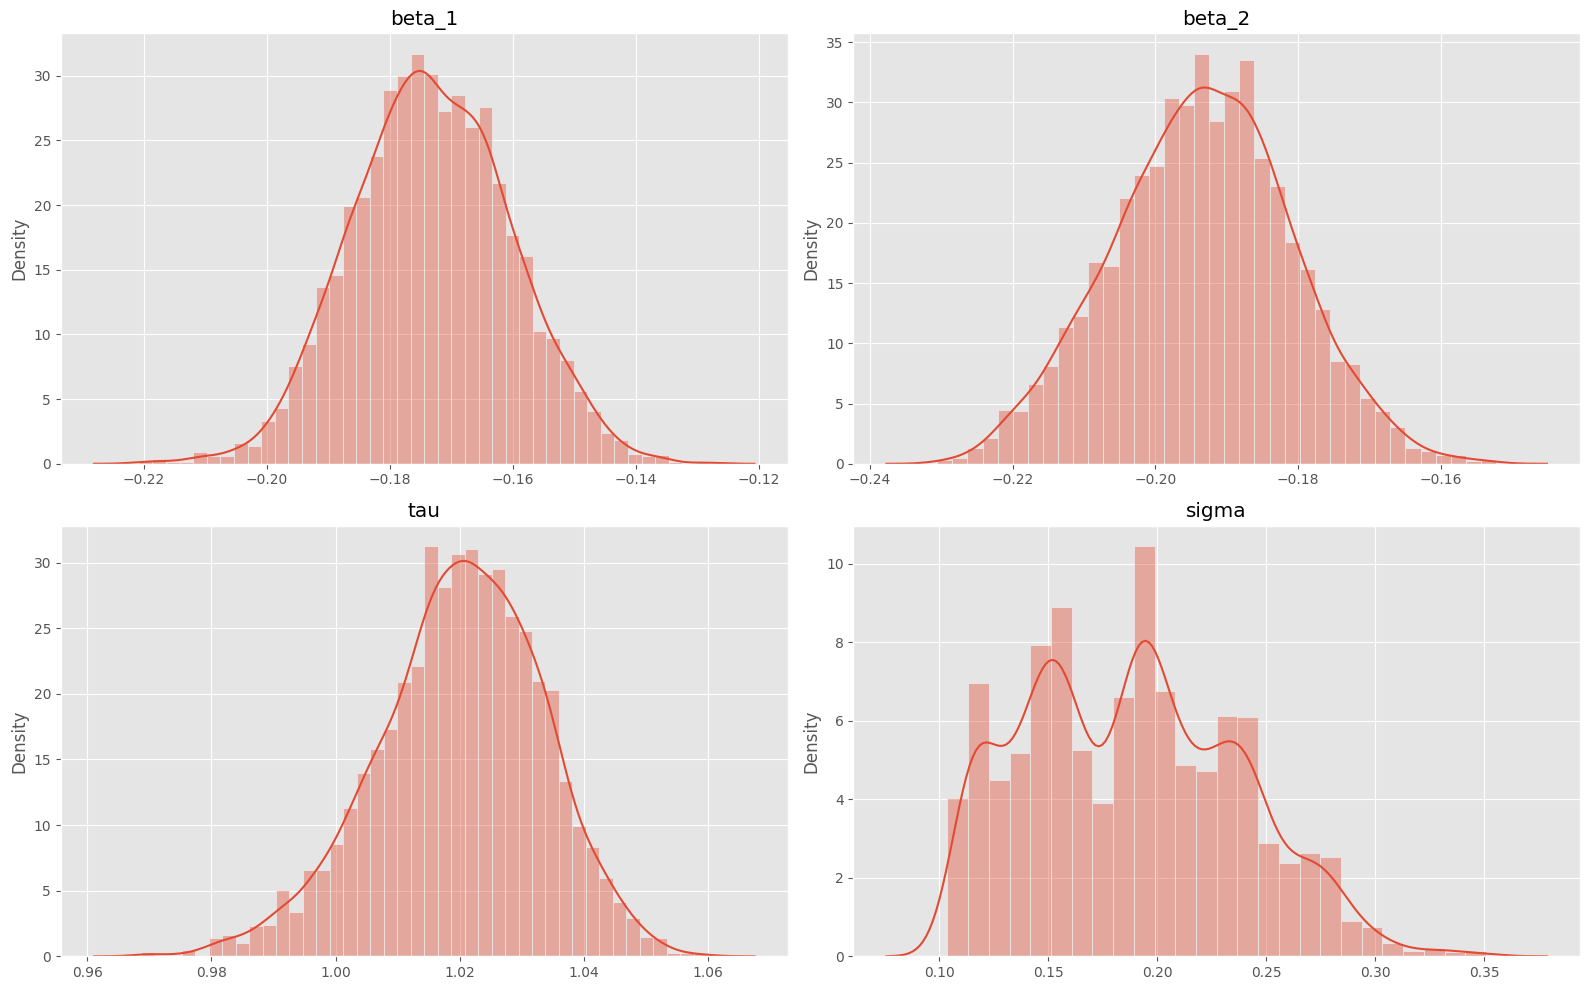

In [69]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

nodes = ["beta_1", "beta_2", "tau", "sigma"]

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, node in enumerate(nodes):
    axes[i].set_title(node)
    _, FD_bins = np.histogram(hmc_samples[node], bins="fd")
    bin_nr = min(len(FD_bins)-1, 50)
    sns.histplot(hmc_samples[node], label=node, stat='density', kde=True, kde_kws={"cut": 3}, ax=axes[i], alpha=0.4)#, bins = bin_nr)
    fig.tight_layout()

Let's see how well our model predicts on the test data!

In [70]:
prediction_samples = hmc_samples["y_pred"]                          # retrieve predictions
temp_list = []
temp_list.extend(np.full(1, np.nan))
temp_list.extend(y_train)
temp_list.extend(prediction_samples.T)
ts_results = ts.copy()
ts_results["diff2"] = temp_list                                                     # update dataframe with predictions
ts_results["pred_std"] = getPriceDomain(ts_results)                                 # transform predictions to non-differenced domain
ts_results["pred"] = ts_results["pred_std"]*ts_std.values[0] + ts_mean.values[0]    # transform to non-standardized domain

In [72]:
from operator import add, sub
y_pred = [i.mean() for i in ts_results['pred']["2019-10-01":]]
y_std = [1.96*i.std() for i in ts_results['pred']["2019-10-01":]]

y_pred_025 = list(map(sub, y_pred, y_std) )
y_pred_975 = list(map(add, y_pred, y_std) )
y_true = ts_results[columnName]["2019-10-01":]
test_index = y_true.index

N_train = len(y_train)
N_test = len(y_test)

price_train = ts_results[columnName][:"2019-10-01"]
price_test = ts_results[columnName]["2019-10-01":]



fig=go.Figure()
fig.add_trace(go.Scatter(
        name='CI',
        x=np.arange(len(y_train),N_train+N_test),
        y=y_pred_975,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        name='CI',
        x=np.arange(len(y_train),N_train+N_test),
        y=y_pred_025,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=True
    ))

fig.add_trace(go.Scatter(name="true train",x=np.arange(6300,N_train) , y=price_train[6300:], marker_color="blue", showlegend=True))

fig.add_trace(go.Scatter(name="forecast",x=np.arange(N_train,N_train+N_test), y=y_pred, marker_color="red", showlegend=True))
fig.add_trace(go.Scatter(mode="markers",name="true (test)",x=np.arange(N_train,N_train+N_test), y=price_test, marker_color="blue", showlegend=True))
fig.show()


Note that there is no spike that is NOT predicted, but there are several spikes predicted that did not get realized.

In [75]:
get_score(y_true, y_pred)

CorrCoeff:  0.6553825954080806
MAE:  0.7324338560432501
RMSE:  26.24974371800992
R2:  0.1481175868535498


/home/emilhelgren/.virtualenvs/master-env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



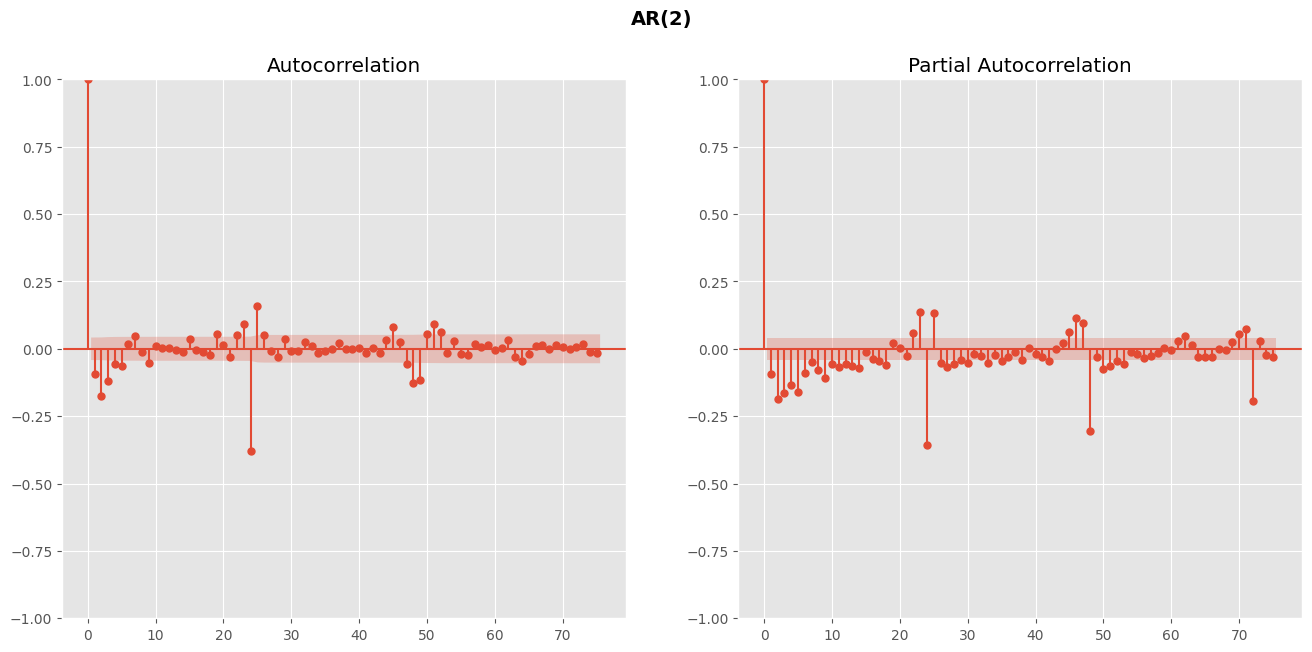

In [76]:
fig, ax = plt.subplots(1,2, figsize=(16,7))
plot_acf(y_true-y_pred, ax=ax[0], lags = 75);
plot_pacf(y_true-y_pred, ax=ax[1], lags = 75);
fig.suptitle("AR(2)", fontsize=14, weight="bold");

In [77]:
def f(carry, noise_t):
    beta1, beta2, beta24, z_prev1, z_prev2 ,z_prev3 ,z_prev4 ,z_prev5 ,z_prev6 ,z_prev7 ,z_prev8 ,z_prev9 ,z_prev10,z_prev11,z_prev12,z_prev13,z_prev14,z_prev15,z_prev16,z_prev17,z_prev18,z_prev19,z_prev20,z_prev21,z_prev22,z_prev23,z_prev24, tau = carry


    z_t = beta1*z_prev1 + beta2*z_prev2 + beta24*z_prev24 + tau*noise_t
    z_prev24 = z_prev23
    z_prev23 = z_prev22
    z_prev22 = z_prev21
    z_prev21 = z_prev20
    z_prev20 = z_prev19
    z_prev19 = z_prev18
    z_prev18 = z_prev17
    z_prev17 = z_prev16
    z_prev16 = z_prev15
    z_prev15 = z_prev14
    z_prev14 = z_prev13
    z_prev13 = z_prev12
    z_prev12 = z_prev11
    z_prev11 = z_prev10
    z_prev10 = z_prev9
    z_prev9 = z_prev8
    z_prev8 = z_prev7
    z_prev7 = z_prev6
    z_prev6 = z_prev5
    z_prev5 = z_prev4
    z_prev4 = z_prev3
    z_prev3 = z_prev2
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, beta24, z_prev1, z_prev2 ,z_prev3 ,z_prev4 ,z_prev5 ,z_prev6 ,z_prev7 ,z_prev8 ,z_prev9 ,z_prev10,z_prev11,z_prev12,z_prev13,z_prev14,z_prev15,z_prev16,z_prev17,z_prev18,z_prev19,z_prev20,z_prev21,z_prev22,z_prev23,z_prev24, tau), z_t

In [78]:
def model(T, T_forecast, obs=None):
    beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=3.))
    beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=3.))
    beta24 = numpyro.sample(name="beta_24", fn=dist.Normal(loc=0., scale=3.))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(T+T_forecast-24,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=3.))
    z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0, scale=5.))
    z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0, scale=5.))
    z_prev3 = numpyro.sample(name="z_3", fn=dist.Normal(loc=0, scale=5.))
    z_prev4 = numpyro.sample(name="z_4", fn=dist.Normal(loc=0, scale=5.))
    z_prev5 = numpyro.sample(name="z_5", fn=dist.Normal(loc=0, scale=5.))
    z_prev6 = numpyro.sample(name="z_6", fn=dist.Normal(loc=0, scale=5.))
    z_prev7 = numpyro.sample(name="z_7", fn=dist.Normal(loc=0, scale=5.))
    z_prev8 = numpyro.sample(name="z_8", fn=dist.Normal(loc=0, scale=5.))
    z_prev9 = numpyro.sample(name="z_9", fn=dist.Normal(loc=0, scale=5.))
    z_prev10 = numpyro.sample(name="z_10", fn=dist.Normal(loc=0, scale=5.))
    z_prev11 = numpyro.sample(name="z_11", fn=dist.Normal(loc=0, scale=5.))
    z_prev12 = numpyro.sample(name="z_12", fn=dist.Normal(loc=0, scale=5.))
    z_prev13 = numpyro.sample(name="z_13", fn=dist.Normal(loc=0, scale=5.))
    z_prev14 = numpyro.sample(name="z_14", fn=dist.Normal(loc=0, scale=5.))
    z_prev15 = numpyro.sample(name="z_15", fn=dist.Normal(loc=0, scale=5.))
    z_prev16 = numpyro.sample(name="z_16", fn=dist.Normal(loc=0, scale=5.))
    z_prev17 = numpyro.sample(name="z_17", fn=dist.Normal(loc=0, scale=5.))
    z_prev18 = numpyro.sample(name="z_18", fn=dist.Normal(loc=0, scale=5.))
    z_prev19 = numpyro.sample(name="z_19", fn=dist.Normal(loc=0, scale=5.))
    z_prev20 = numpyro.sample(name="z_20", fn=dist.Normal(loc=0, scale=5.))
    z_prev21 = numpyro.sample(name="z_21", fn=dist.Normal(loc=0, scale=5.))
    z_prev22 = numpyro.sample(name="z_22", fn=dist.Normal(loc=0, scale=5.))
    z_prev23 = numpyro.sample(name="z_23", fn=dist.Normal(loc=0, scale=5.))
    z_prev24 = numpyro.sample(name="z_24", fn=dist.Normal(loc=0, scale=5.))

    


    carry = (beta1, beta2, beta24, z_prev1, z_prev2 ,z_prev3 ,z_prev4 ,z_prev5 ,z_prev6 ,z_prev7 ,z_prev8 ,z_prev9 ,z_prev10,z_prev11,z_prev12,z_prev13,z_prev14,z_prev15,z_prev16,z_prev17,z_prev18,z_prev19,z_prev20,z_prev21,z_prev22,z_prev23,z_prev24, tau)
    z_collection = [z_prev1, z_prev2 ,z_prev3 ,z_prev4 ,z_prev5 ,z_prev6 ,z_prev7 ,z_prev8 ,z_prev9 ,z_prev10,z_prev11,z_prev12,z_prev13,z_prev14,z_prev15,z_prev16,z_prev17,z_prev18,z_prev19,z_prev20,z_prev21,z_prev22,z_prev23,z_prev24]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-24)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    return z_collection

In [79]:
# Split dataset
y_train = ts["diff2"][:"2019-10-01"].dropna().to_numpy()
y_test = ts["diff2"]["2019-10-01":].to_numpy()


# Run algorithm
mcmc = run_MCMC(model, y_train, len(y_train), len(y_test))

sample: 100%|██████████| 5000/5000 [15:23<00:00,  5.41it/s, 255 steps of size 5.00e-03. acc. prob=0.27]

Total time: 15.674m


Let's take a look at the parameter distributions. 

<AxesSubplot: title={'center': 'beta_24'}, ylabel='Density'>

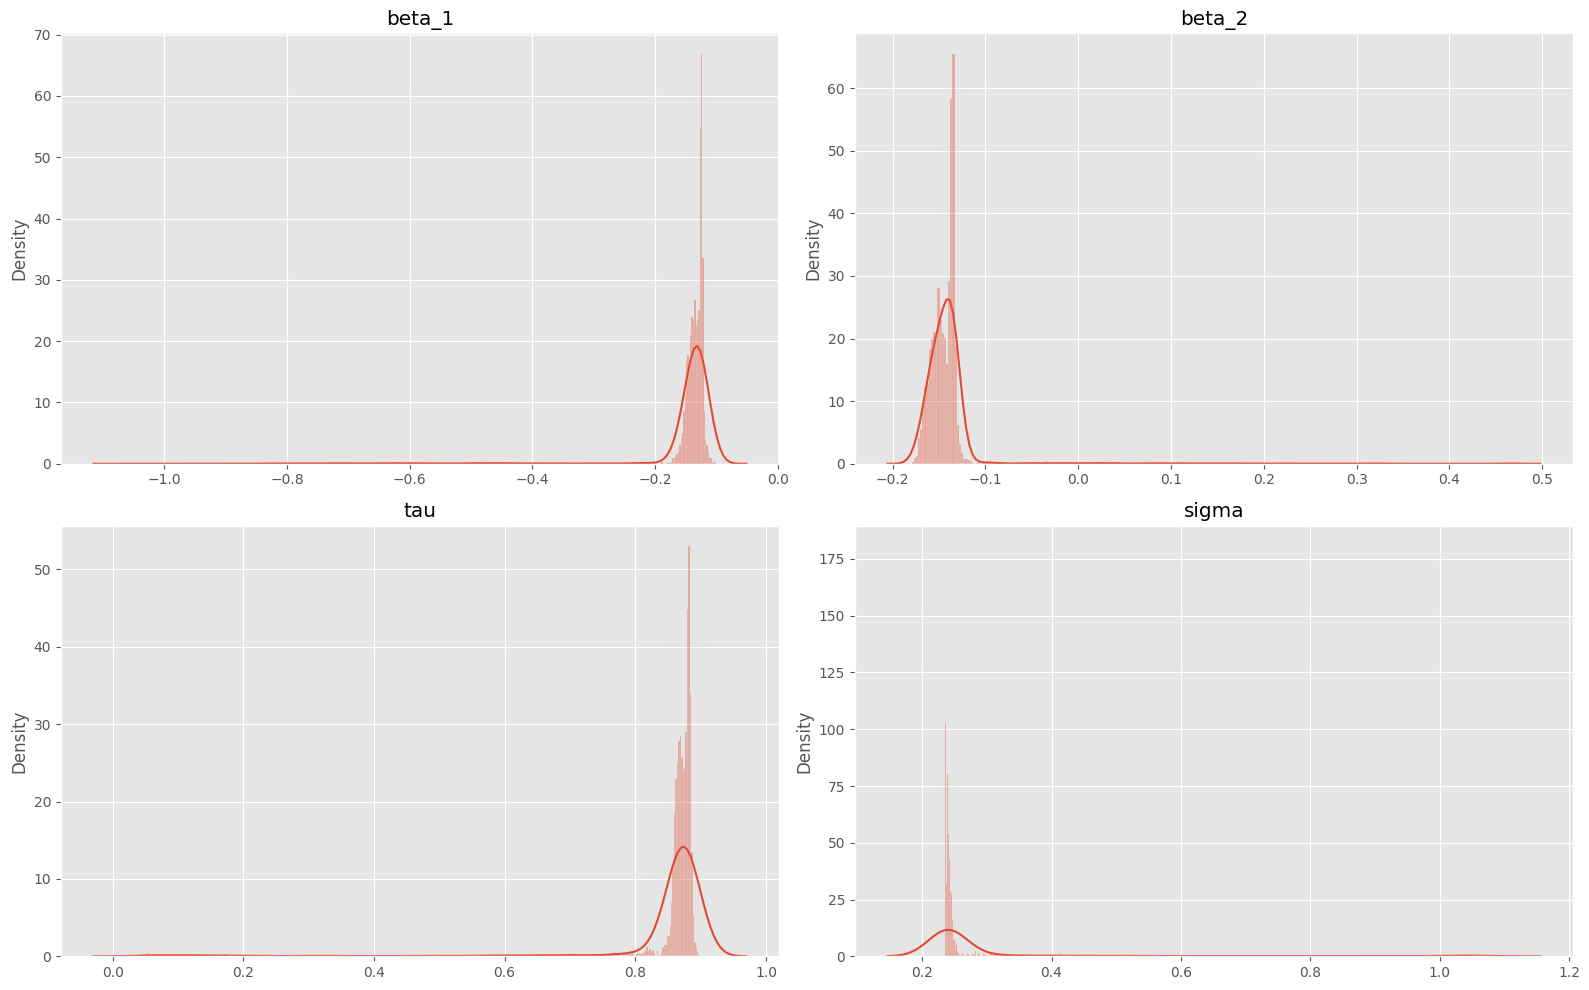

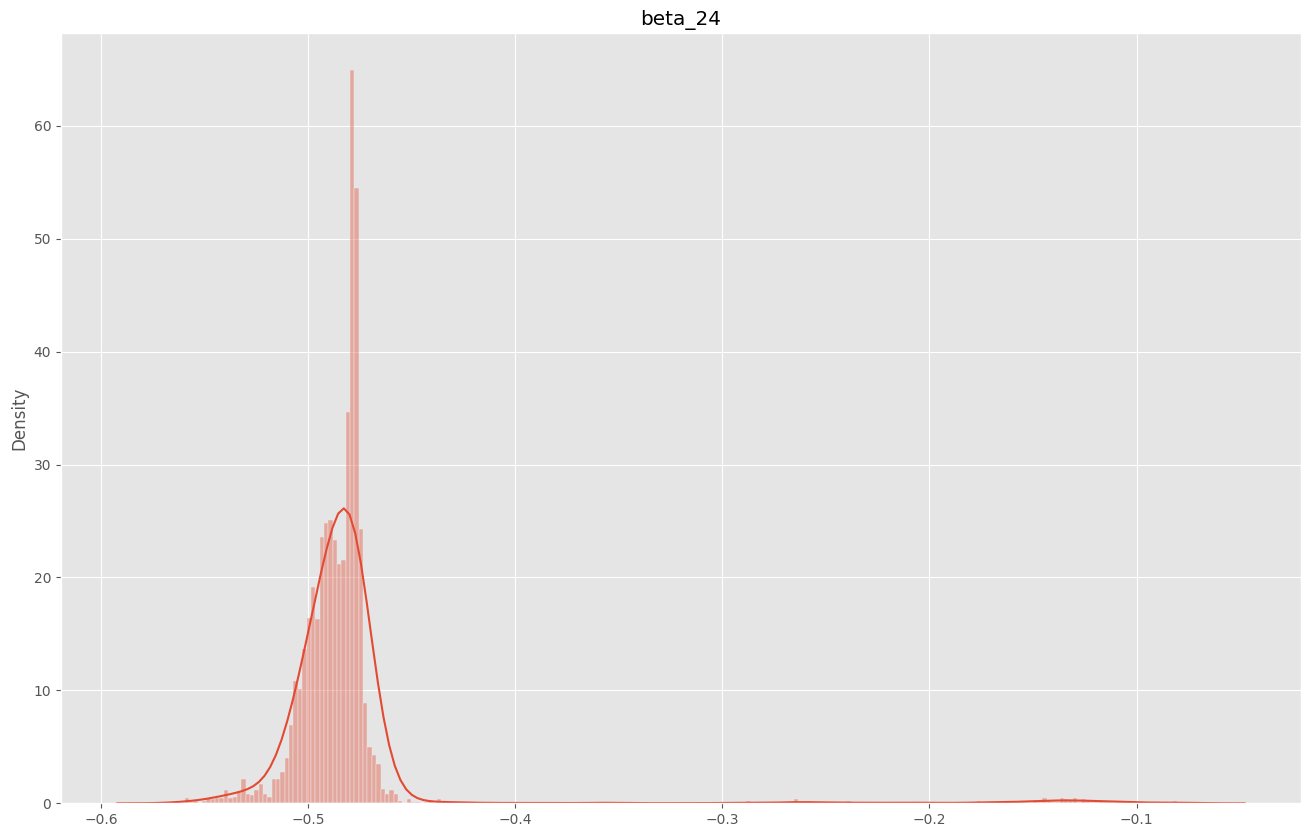

In [80]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

nodes = ["beta_1", "beta_2", "tau", "sigma"]

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, node in enumerate(nodes):
    axes[i].set_title(node)
    _, FD_bins = np.histogram(hmc_samples[node], bins="fd")
    bin_nr = min(len(FD_bins)-1, 50)
    sns.histplot(hmc_samples[node], label=node, stat='density', kde=True, kde_kws={"cut": 3}, ax=axes[i], alpha=0.4)#, bins = bin_nr)
    fig.tight_layout()


f2, axis = plt.subplots(1, 1)
axis.set_title("beta_24")
_, FD_bins = np.histogram(hmc_samples["beta_24"], bins="fd")
bin_nr = min(len(FD_bins)-1, 50)
sns.histplot(hmc_samples["beta_24"], label="beta_24", stat='density', kde=True, kde_kws={"cut": 3}, ax=axis, alpha=0.4)

Now we see $\beta_{24}$ with a relatively large negative value, but $\beta_1$ and $\beta_2$ is much closer to 0. There is a small interesting amount of samples around -0.1 for $\beta_{24}$ - perhaps there is a non-linear relationship with some (unknown) attribute that determines whether the price 24h previous should have a parameter of ~(-0.45) or ~(-0.1).


We create an interactive plot like before:

In [81]:
prediction_samples = hmc_samples["y_pred"]                          # retrieve predictions
temp_list = []
temp_list.extend(np.full(1, np.nan))
temp_list.extend(y_train)
temp_list.extend(prediction_samples.T)
ts_results = ts.copy()
ts_results["diff2"] = temp_list                                                     # update dataframe with predictions
ts_results["pred_std"] = getPriceDomain(ts_results)                                 # transform predictions to non-differenced domain
ts_results["pred"] = ts_results["pred_std"]*ts_std.values[0] + ts_mean.values[0]    # transform to non-standardized domain

In [83]:

y_pred = [i.mean() for i in ts_results['pred']["2019-10-01":]]
y_std = [1.96*i.std() for i in ts_results['pred']["2019-10-01":]]

y_pred_025 = list(map(sub, y_pred, y_std) )
y_pred_975 = list(map(add, y_pred, y_std) )
y_true = ts_results[columnName]["2019-10-01":]
test_index = y_true.index

N_train = len(y_train)
N_test = len(y_test)

price_train = ts_results[columnName][:"2019-10-01"]
price_test = ts_results[columnName]["2019-10-01":]



fig=go.Figure()
fig.add_trace(go.Scatter(
        name='CI',
        x=np.arange(len(y_train),N_train+N_test),
        y=y_pred_975,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        name='CI',
        x=np.arange(len(y_train),N_train+N_test),
        y=y_pred_025,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=True
    ))

fig.add_trace(go.Scatter(name="true train",x=np.arange(6300,N_train) , y=price_train[6300:], marker_color="blue", showlegend=True))

fig.add_trace(go.Scatter(name="forecast",x=np.arange(N_train,N_train+N_test), y=y_pred, marker_color="red", showlegend=True))
fig.add_trace(go.Scatter(mode="markers",name="true (test)",x=np.arange(N_train,N_train+N_test), y=price_test, marker_color="blue", showlegend=True))
fig.show()


It's hard to say whether this is any better than before. Let's take a look at the scores.

In [85]:
get_score(y_true, y_pred)

CorrCoeff:  0.6276120546124049
MAE:  1.0610227723590728
RMSE:  27.943135667269736
R2:  0.03466112537504973


Seems worse than before

# This is how far i got

<a name="part6"></a>
# 6 Final model

The final model adds the $X$ data with both weather and original time data on top of the AR(2) model, since that performed better than when we included the AR(1)$_{24}$ term, thus utilizing all the predictive power possible. This means we both account for time by the dummy variables in $X$ as well as the AR terms. Let's do it!

The carry function and model definition is modified so we have a tuple consisting of an $x_t$-vector with weather and time data and the noise value, instead of only the noise. 

We lost the first 25 values when we entered the differenciated temporal domain, so we define an offset to account for that in our $X$-vector so we can offset correctly in the model. We also have an offset for the 2 initial $z$ values that we need to sample. 

In [ ]:
X_train = X[:"2019-10-01"].to_numpy()
X_test = X["2019-10-01":].to_numpy()
y_train = ts['diff2'][:"2019-10-01"].to_numpy()
y_test = ts['diff2']["2019-10-01":].to_numpy()
X_total = X.to_numpy()

N_train = len(y_train)
N_test = len(y_test)

offset1 = 2
offset2 = 25

In [ ]:
def f(carry, input_t):
    beta1, beta2, z_prev1, z_prev2, W, tau = carry
    x_t = input_t[0]
    noise_t = input_t[1]
    z_t = beta1*z_prev1 + beta2*z_prev2 + jnp.dot(W,x_t) + tau*noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, z_prev1, z_prev2, W, tau), z_t

In [ ]:
def model(T, T_forecast, xs, obs=None):
    beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=3.))
    beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=3.))
    W = numpyro.sample(name="w", fn=dist.Normal(loc=np.zeros(X_train.shape[1]), scale=np.ones(X_train.shape[1])*3.))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(T+T_forecast-offset1,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=1.))
    z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0, scale=5.))
    z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0, scale=5.))    

    inputs = (xs[offset1:,:],noises)

    carry = (beta1, beta2, z_prev1, z_prev2, W, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f, carry, inputs, T+T_forecast-offset1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs)
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    return z_collection

We now have to input our weather data in our model, so we can't reuse the MCMC function from before directly. We use the same hyperparameters though, so the only new thing is the weather data in the $X$ variable.

In [ ]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N_train-offset2, T_forecast=N_test, xs=X_total, obs=y_train[offset2:])

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))


sample: 100%|██████████| 5000/5000 [27:03<00:00,  3.08it/s, 255 steps of size 5.00e-03. acc. prob=0.91]


Total time: 27.188m


Let's first plot the usual distributions of $\beta$ and the variances.

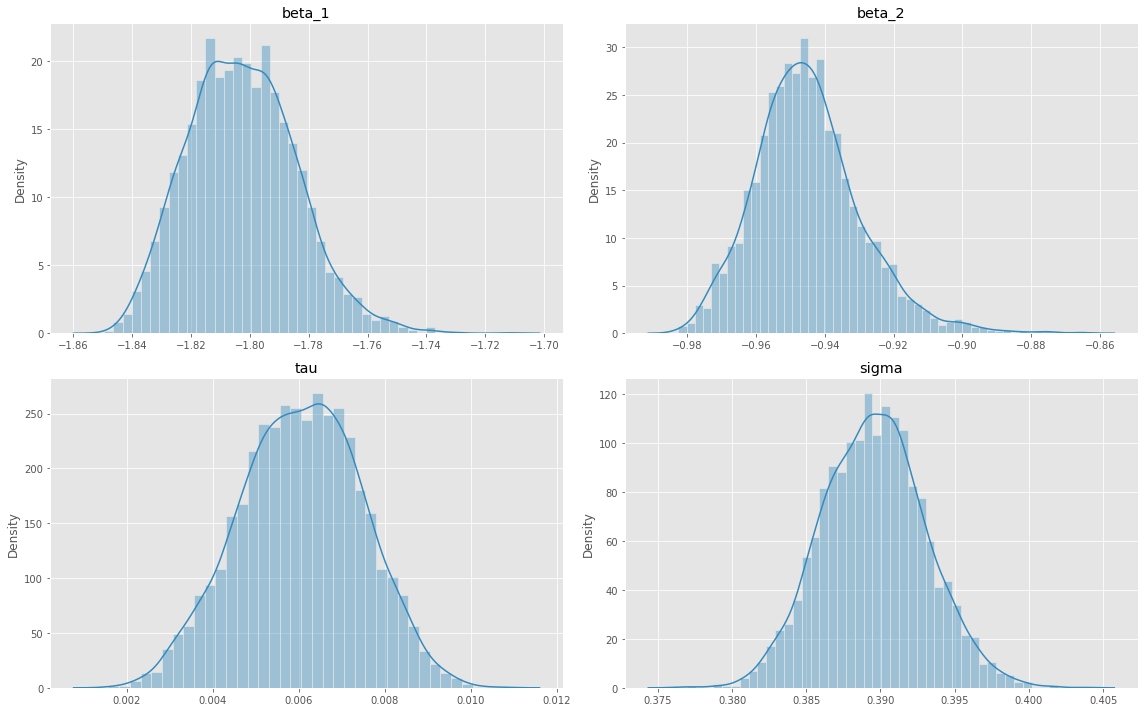

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

nodes = ["beta_1", "beta_2", "tau", "sigma"]

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, node in enumerate(nodes):
    axes[i].set_title(node)
    _, FD_bins = np.histogram(hmc_samples[node], bins="fd")
    bin_nr = min(len(FD_bins)-1, 50)
    sns.histplot(hmc_samples[node], label=node, stat='density', kde=True, kde_kws={"cut": 3}, ax=axes[i], alpha=0.4)#, bins = bin_nr)
    fig.tight_layout()


Now we have both $\beta$ values taking a value significantly different from 0, and $\tau$ again takes a very small value, indicating that $\sigma$ accounts for all the randomness in the observations. 

$W$ has 35 attributes, so let's stick to plotting the distributions of the weather data.

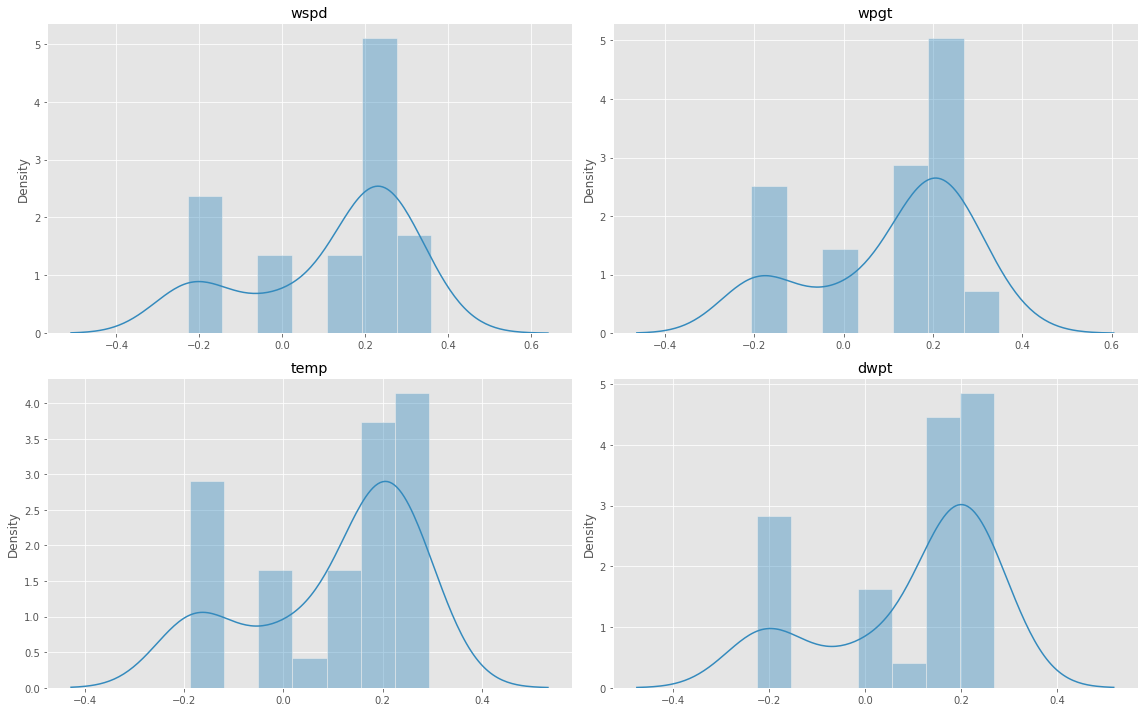

In [ ]:

nodes = X.columns[:4]

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for i, node in enumerate(nodes):
    axes[i].set_title(node)
    _, FD_bins = np.histogram(hmc_samples["w"][i], bins="fd")
    bin_nr = min(len(FD_bins)-1, 50)
    sns.histplot(hmc_samples["w"][i], label=node, stat='density', kde=True, kde_kws={"cut": 3}, ax=axes[i], alpha=0.4)#, bins = bin_nr)
    fig.tight_layout()

All the weather attributes have very similar distributions, and shows a mode on either side of 0. This indicates that the weather attributes might not contribute with any consistent improvement.

Let's create the final plot and get the model scores.

In [ ]:
prediction_samples = hmc_samples["y_pred"]                          # retrieve predictions
temp_list = []
temp_list.extend(np.full(1, np.nan))
temp_list.extend(y_train[offset2:])
temp_list.extend(prediction_samples.T)
ts_results = ts.copy()
ts_results["diff2"] = temp_list                                                     # update dataframe with predictions
ts_results["pred_std"] = getPriceDomain(ts_results)                                 # transform predictions to non-differenced domain
ts_results["pred"] = ts_results["pred_std"]*ts_std.values[0] + ts_mean.values[0]    # transform to non-standardized domain

In [ ]:
y_pred = [i.mean() for i in ts_results['pred']["2019-10-01":]]
y_std = [1.96*i.std() for i in ts_results['pred']["2019-10-01":]]

y_pred_025 = list(map(sub, y_pred, y_std) )
y_pred_975 = list(map(add, y_pred, y_std) )
y_true = ts_results["SpotPriceDKK"]["2019-10-01":]
test_index = y_true.index

N_train = len(y_train)
N_test = len(y_test)

price_train = ts_results["SpotPriceDKK"][:"2019-10-01"]
price_test = ts_results["SpotPriceDKK"]["2019-10-01":]



fig=go.Figure()
fig.add_trace(go.Scatter(
        name='CI',
        x=np.arange(len(y_train),N_train+N_test),
        y=y_pred_975,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ))

fig.add_trace(go.Scatter(
        name='CI',
        x=np.arange(len(y_train),N_train+N_test),
        y=y_pred_025,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=True
    ))

fig.add_trace(go.Scatter(name="true train",x=np.arange(6300,N_train) , y=price_train[6300:], marker_color="blue", showlegend=True))

fig.add_trace(go.Scatter(name="forecast",x=np.arange(N_train,N_train+N_test), y=y_pred, marker_color="red", showlegend=True))
fig.add_trace(go.Scatter(mode="markers",name="true (test)",x=np.arange(N_train,N_train+N_test), y=price_test, marker_color="blue", showlegend=True))
fig.show()

In [ ]:
get_score(y_true, y_pred)

CorrCoeff:  0.9163759266434244
MAE:  0.3506721354944583
RMSE:  35.962458906734135
R2:  0.8217514858738963


Almost equal scores to the simple AR(2) model - actually a bit lower but this might very well be due to randomness in the initial sampling. 

<a name="part7"></a>
# 7 Conclusion
This concludes the modelling in this notebook. We showed that weather data combined with dummy variables for time indicatinos was somewhat useful in predicting the price, but the simple AR(2) model actually outperformed everything else. 

Looking close at the interactive plot of the AR(2) model, we see that the model rarely misses a true large change in price, but rather often predict a large change in price that didn't happen. In other words, the model predicts a larger degree of volatility in the price, than what is observed in the true price. 

On the picture below, a few examples of this are highlighted on the plot. Here we see examples of the model forecasting large spikes that are not present in the true model at all. In the two right-most highlights, we see periods of very stable price action, but the model predicts significant fluctuations. A large amount of the time though, the true price is either almost exactly equal to the forecast, or at least within the confidence interval.

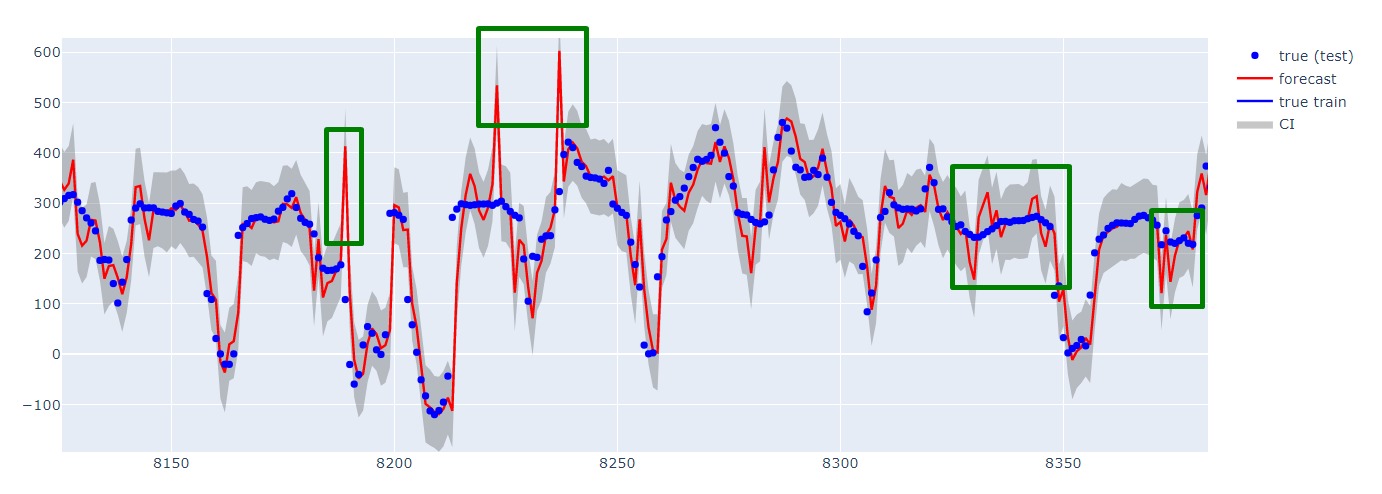

Let's define a function that plots some overview of the models performancce

In [ ]:
def plot_dow_hod(df_test, y_test):
    df = df_test.copy()
    df["pred"] = np.array(y_test)

    df = add_calendar_features(df)
    
    df_test_dow = df.groupby(["Day of Week"]).mean().reset_index()
    df_test_hod = df.groupby(["Hour"]).mean().reset_index()

    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    fig = make_subplots(rows=1, cols=2, subplot_titles=["Hour of Day", "Day of Week", "Overall"])

    fig.update_layout(
        barmode='group',
        title_text="Predicted vs actual values by hour of day and day of week"
    )
    
    hods = ["0"+str(i)+":00" if i < 10 else str(i)+":00" for i in range(0,24)]
    dows = [calendar.day_abbr[i] for i in df_test_dow["Day of Week"]]

    
    fig.append_trace(go.Bar(name='Predicted', x=months, y=df_test_hod["pred"], marker_color="red"), row=1, col=1)
    fig.append_trace(go.Bar(name='Predicted', x=dows, y=df_test_dow["pred"], showlegend=False, marker_color="red"), row=1, col=2)
        
    fig.append_trace(go.Bar(name='Actual', x=months, y=df_test_hod["SpotPriceDKK"], marker_color="blue"), row=1, col=1)
    fig.append_trace(go.Bar(name='Actual', x=dows, y=df_test_dow["SpotPriceDKK"], showlegend=False, marker_color="blue"), row=1, col=2)
    
    fig.update_yaxes(title_text="Average electricity price DKK/MWh", row=1, col=1)
    
    fig.show()

In [ ]:
# Note that we ran the AR(2) cells again such that the y_pred variable holds the predictions from the AR(2) model and not the last model.
plot_dow_hod(ts_results[["SpotPriceDKK"]]["2019-10-01":], y_pred) 

Of course the averaging of the values is expected to yield even better results, since the error of the model is mostly in the increased volatility, which would not affect the average of the predicted values.

### Additional features
The confidence intervals of the models were quite wide indicating uncertainty in the prediction. As the electricity price by no means is an easy entity to predict this is not unexpected, however, as data scientists we always strive for better models. One extension to the model could be to include additional features such as the price of other energy sources such as oil and gas. The marginal cost of generating electricity is heavily influenced by these and thus should be correlated with the electricity price. The same reasoning can be applied to all quantifiable metrics that are related to either the supply or demand of energy. This is definitely an area worth investigating in future work! 

### More data
The time horizon of the data was chosen to be the year of 2019. This was mainly to ensure that the distribution of the electricity price was similar throughout the period. If we had included 2020, the data would have been greatly impacted by the Covid-19 crisis, which drastically changed the patterns of the electricity price. However, what is the model worth if it cannot be used in unprecedented time periods? Following this chain of thought and the reflections in the above section, it is evident that for a multi-year forecast model it is necessary to construct a model that allows the patterns and behavior of the electricity price to change. The fact that the final model is a temporal model should to some extent be able to account for this. However, again it would be interesting to see the performance of the model if the time period was an entire decade. Perhaps a dynamic variance throughout the years would be necessary?

### Multivariate LDS with external inputs
The fact that the electricity grid of Northern Europe is connected means that the electricity price is correlated. To widen the area of the research it could have been interesting to look at several geographical areas and construct at multivariate model. In this case, the electricity price of the geographical areas would be sampled from a multivariate normal distribution with a covariance accounting for the correlation between the prices. If the electricity price was missing at one area, the information from the other areas would allow for imputation. 

### Value of the results
The performance of the best model has an RMSE of 35.82 and a R2 score of 0.823. This is generally speaking a very high prediction level considering the nature of the data. However, as the models only predicts one hour ahead, the value of the model may be limited. In fact, an estimated electricity price is determined 24 hours ahead on the NordPool exchange based on bids from the electricity suppliers. Our prediction of the electricity price is thus only valuable for the intra-day price setting and not the day-ahead market, which is a significant limitation when considering real-life application. However, looking at the bigger picture it is indeed very valuable to be able to predict the future in energy domain and other domains such as the transport domain.